Baseline Model from https://github.com/CVxTz/ECG_Heartbeat_Classification/blob/master/code/baseline_ptbdb.py

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from keras.initializers import glorot_uniform
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve

In [17]:
df_1 = pd.read_csv("../input/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("../input/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [18]:
# Pieces of code copied from 2dResNet: https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Convolution1D(filters=F1, kernel_size=3, padding='same', name=conv_name_base + 'a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Convolution1D(filters=F2, kernel_size=f, padding='same', name=conv_name_base + 'b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Convolution1D(filters=F3, kernel_size=1, padding='same', name=conv_name_base + 'c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Convolution1D(filters=F3, kernel_size=1, padding='valid', name=conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [19]:
# Pieces of code copied from 2dResNet: https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Convolution1D(filters = F1, kernel_size = 3, activation=activations.relu, padding = 'same', name = conv_name_base + 'a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'a')(X)
#     X = Activation('relu')(X)
    
    # Second component of main path
    X = Convolution1D(filters = F2, kernel_size = f, activation=activations.relu, padding = 'same', name = conv_name_base + 'b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'b')(X)
#     X = Activation('relu')(X)

    # Third component of main path 
    X = Convolution1D(filters = F3, kernel_size = 1, activation=activations.relu, padding = 'same', name = conv_name_base + 'c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + 'c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [26]:
# Pieces of code copied from 2dResNet: https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff
def get_model():
    nclass = 1
    inp = Input(shape=(187, 1))
    
    # Stage 1
    img_1 = Convolution1D(16, 3, name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(inp)
    img_1 = BatchNormalization(name = 'bn_conv1')(img_1)
    img_1 = Activation('relu')(img_1)
    img_1 = MaxPool1D(pool_size=3, strides=2)(img_1)

    # Stage 2
    img_1 = convolutional_block(img_1, f = 3, filters = [16, 16, 64], stage = 2, block='a', s = 1)
    img_1 = identity_block(img_1, 3, [16, 16, 64], stage=2, block='b')
    img_1 = identity_block(img_1, 3, [16, 16, 64], stage=2, block='c')

    # Stage 3
    img_1 = convolutional_block(img_1, f=3, filters=[32, 32, 64], stage=3, block='a', s=2)
    img_1 = identity_block(img_1, 3, [32, 32, 64], stage=3, block='b')
    img_1 = identity_block(img_1, 3, [32, 32, 64], stage=3, block='c')
    img_1 = identity_block(img_1, 3, [32, 32, 64], stage=3, block='d')

    # Stage 4
    img_1 = convolutional_block(img_1, f=3, filters=[32, 32, 128], stage=4, block='a', s=2)
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='b')
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='c')
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='d')
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='e')
    img_1 = identity_block(img_1, 3, [32, 32, 128], stage=4, block='f')

    # Stage 5
    img_1 = convolutional_block(img_1, f=3, filters=[16, 16, 64], stage=5, block='a', s=2)
    img_1 = identity_block(img_1, 3, [16, 16, 64], stage=5, block='b')
    img_1 = identity_block(img_1, 3, [16, 16, 64], stage=5, block='c')

    # AVGPOOL
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [ ]:
model = get_model()
file_path = "baseline_cnn_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
# callbacks_list = [checkpoint, early, redonplat]  # early
callbacks_list = [early, redonplat]  # checkpoint returns an error for ResCNN

In [31]:
model.fit(X, Y, epochs=13, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/13
328/328 [==============================] - 29s 78ms/step - loss: 0.5176 - acc: 0.7264 - val_loss: 0.5161 - val_acc: 0.6996
Epoch 2/13
328/328 [==============================] - 25s 75ms/step - loss: 0.4688 - acc: 0.7500 - val_loss: 0.4642 - val_acc: 0.7665
Epoch 3/13
328/328 [==============================] - 25s 76ms/step - loss: 0.4301 - acc: 0.7808 - val_loss: 0.3809 - val_acc: 0.8352
Epoch 4/13
328/328 [==============================] - 25s 75ms/step - loss: 0.3763 - acc: 0.8214 - val_loss: 0.3509 - val_acc: 0.8515
Epoch 5/13
328/328 [==============================] - 25s 76ms/step - loss: 0.3143 - acc: 0.8614 - val_loss: 0.2918 - val_acc: 0.8824
Epoch 6/13
328/328 [==============================] - 25s 76ms/step - loss: 0.2745 - acc: 0.8853 - val_loss: 0.2984 - val_acc: 0.8652
Epoch 7/13
328/328 [==============================] - 25s 76ms/step - loss: 0.2567 - acc: 0.8930 - val_loss: 0.2825 - val_acc: 0.8755
Epoch 8/13
328/328 [==============================] - 25s 76ms

In [32]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.943237907206318 
Test accuracy score : 0.9209893507385778 


In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, pred_test)
auc_keras = auc(fpr_keras, tpr_keras)
print("AUROC score : %s "% auc_keras)

AUROC score : 0.9304632470811836 


In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, pred_test)
auroc = auc(fpr, tpr)
print("AUROC score : %s "% auroc)

AUROC score : 0.9304632470811836 


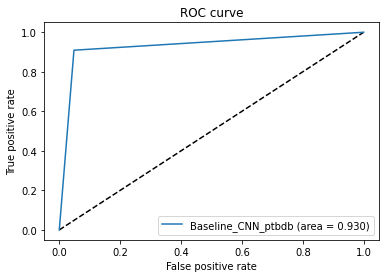

In [35]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Baseline_CNN_ptbdb (area = {:.3f})'.format(auroc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('AUROC_CNN_baseline_ptbdb.png')
plt.show()

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(Y_test, pred_test)
# calculate the precision-recall auc
auprc = auc(recall, precision)
print("AUPRC score : %s "% auprc)

AUPRC score : 0.9773736746439977 


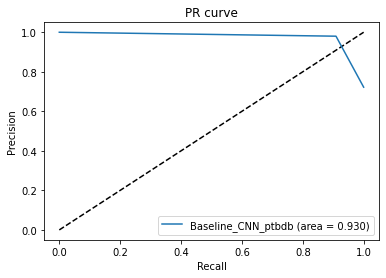

In [37]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall, precision, label='Baseline_CNN_ptbdb (area = {:.3f})'.format(auroc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.savefig('AUPRC_CNN_baseline_ptbdb.png')
plt.show()